In [1]:
%matplotlib notebook
import sys, os, tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TVF
import matplotlib.pyplot as plt
import seaborn as sns
torch.cuda.is_available()

True

In [2]:
download = False

url = 'https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip'

def download_and_unzip(url, output_path):
    import urllib, io, zipfile
    with urllib.request.urlopen(url) as f:
        zip_file = zipfile.ZipFile(io.BytesIO(f.read()))
        zip_file.extractall(path=output_path)

data_root = './cifar10'
train_set_dir = os.path.join(data_root, 'cifar10_train')
test_set_dir = os.path.join(data_root, 'cifar10_test')

if download:
    download_and_unzip(url, data_root)
    
os.listdir(data_root)

['cifar10_train', 'cifar10_test']

# Part A - Custom data loader

In [3]:
identity = lambda x: x

class CifarDataset(torch.utils.data.Dataset):
    '''
    CIFAR10 dataset for image classification.
    '''
    label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    label_size = 10
    data_shape = (3, 32, 32)

    def __init__(self, images, labels, image_transform=identity, label_transform=identity, device='cpu'):
        super().__init__()
        assert len(images) == len(labels)
        self.images = images
        self.labels = labels
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.device = device
    
    @classmethod
    def from_dir(cls, root_dir, *args, **kwargs):
        images, labels = [], []
        for label_idx, label in enumerate(cls.label_map):
            label_dir = os.path.join(root_dir, label)
            for image_name in sorted(os.listdir(label_dir)):
                image_file = os.path.join(label_dir, image_name)
                images.append(image_file)
                labels.append(label_idx)
        return cls(images, labels, *args, **kwargs)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = torchvision.io.read_image(image_file)
        label = torch.as_tensor(self.labels[idx])
        assert image.shape == self.data_shape and label < self.label_size

        # apply transforms
        image = self.image_transform(image).to(self.device)
        label = self.label_transform(label).to(self.device)
        return image, label
    
    def select(self, inds):
        images = [self.images[i] for i in inds]
        labels = [self.labels[i] for i in inds]
        return CifarDataset(images, labels, self.image_transform, self.label_transform, self.device)
    
    def sample(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        sampled_inds = shuffled_inds[:n]
        return self.select(sampled_inds)
    
    def split(self, n, seed=None):
        np.random.seed(seed)
        shuffled_inds = np.random.permutation(len(self))
        train_inds, test_inds = np.split(shuffled_inds, [n])
        train_data = self.select(train_inds)
        test_data = self.select(test_inds)
        return train_data, test_data 


train_dataset = CifarDataset.from_dir(train_set_dir)
train_dataset[0]

(tensor([[[202, 202, 204,  ..., 207, 205, 203],
          [206, 206, 207,  ..., 210, 208, 206],
          [210, 211, 212,  ..., 214, 212, 210],
          ...,
          [218, 210, 194,  ..., 243, 244, 243],
          [219, 217, 216,  ..., 241, 241, 241],
          [217, 216, 217,  ..., 239, 239, 240]],
 
         [[204, 204, 206,  ..., 208, 206, 204],
          [208, 208, 209,  ..., 211, 209, 207],
          [212, 213, 214,  ..., 214, 213, 211],
          ...,
          [217, 209, 194,  ..., 242, 242, 243],
          [218, 216, 216,  ..., 240, 240, 240],
          [216, 215, 216,  ..., 238, 238, 238]],
 
         [[199, 199, 201,  ..., 200, 199, 198],
          [203, 203, 204,  ..., 205, 203, 201],
          [207, 208, 210,  ..., 210, 208, 206],
          ...,
          [222, 214, 198,  ..., 247, 247, 247],
          [223, 221, 220,  ..., 245, 245, 245],
          [221, 220, 221,  ..., 243, 243, 243]]], dtype=torch.uint8),
 tensor(0))

In [4]:
n_rows = 2
n_cols = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8.5, 8.5 * n_rows/n_cols))

N = len(train_dataset)
inds = np.random.choice(range(N), size=(n_rows, n_cols), replace=False)

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row, col]

        image, label = train_dataset[inds[row, col]]
        label = train_dataset.label_map[label]

        ax.imshow(image.permute(1, 2, 0)) # CHW -> HWC
        ax.text(
            0.024, 0.048, f'{label}', transform=ax.transAxes,
            bbox=dict(alpha=0.5, fc='white', lw=0)
        )
        ax.axis('off')

fig.tight_layout()

<IPython.core.display.Javascript object>

# Part B - Training neural networks

In [5]:
class MultiLayerPerceptronModel(torch.nn.Module):
    '''
    A three layer neural network.
    '''
    def __init__(self, n_input, n_hidden, n_output, activ_fn, dropout):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_output)
        self.activ_fn = getattr(torch.nn.functional, activ_fn)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        z = self.activ_fn(self.fc1(x))
        z_drop = self.dropout(z)
        return self.fc2(z_drop)

In [26]:
@torch.no_grad
def compute_accuracy(yp, yt):
    return (yp.argmax(dim=1) == yt.argmax(dim=1)).float().mean()


class TrainingPlot(object):
    '''
    Interactive training plot.
    '''
    def __init__(self):
        
        # create subplots for loss and accuracy
        self.fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].set_ylabel('loss')
        ax[1].set_ylabel('accuracy')
        for ax_ in ax:
            ax_.set_axisbelow(True)
            ax_.grid(linestyle=':')
            ax_.set_xlabel('iteration')
        self.fig.tight_layout()
        
        # store data and artists for interactive ploting
        self.data = pd.DataFrame(columns=['iter', 'phase', 'loss', 'accy'])

        self.train_loss_line = ax[0].plot([], [], label='train')[0]
        self.test_loss_line  = ax[0].plot([], [], label='test')[0]
        self.train_accy_line = ax[1].plot([], [], label='train')[0]
        self.test_accy_line  = ax[1].plot([], [], label='test')[0]
        
    def draw(self, pad=1e-8):
        ax = self.fig.get_axes()
        ax[0].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[0].set_ylim(0, self.data.loss.max() * 1.1 + pad)
        ax[1].set_xlim(0, self.data.iter.max() * 1.1 + pad)
        ax[1].set_ylim(0, self.data.accy.max() * 1.1 + pad)
        self.fig.canvas.draw()
        
    def update_train(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'train', loss.item(), accy.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        train = data.loc['train'].reset_index()
        if isinstance(train, pd.Series): # need > 1 rows
            return
        
        self.train_loss_line.set_xdata(train.iter)
        self.train_loss_line.set_ydata(train.loss)

        self.train_accy_line.set_xdata(train.iter)
        self.train_accy_line.set_ydata(train.accy)

        self.draw()
        
    def update_test(self, iteration, loss, accy):
        self.data.loc[len(self.data)] = [iteration, 'test', loss.item(), accy.item()]
        
        data = self.data.groupby(['phase', 'iter']).mean()
        test = data.loc['test'].reset_index()
        if isinstance(test, pd.Series): # need > 1 rows
            return
        
        self.test_loss_line.set_xdata(test.iter)
        self.test_loss_line.set_ydata(test.loss) 
        
        self.test_accy_line.set_xdata(test.iter)
        self.test_accy_line.set_ydata(test.accy)
        
        self.draw()

In [27]:
def training(dataset, model, optimizer, batch_size, n_epochs, verbose=False):

    # split dataset and create data loaders
    train_set, test_set = dataset.split(n=int(0.9 * len(dataset)), seed=0)
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=True
    )
    
    # set model to training mode
    model.train()
    
    # loss and accuracy metrics
    loss_fn = F.cross_entropy
    accy_fn = compute_accuracy

    # setup training plot
    plot = TrainingPlot()
    
    if verbose:
        epoch_iterator = range(n_epochs)
    else:
        epoch_iterator = tqdm.tqdm(range(n_epochs), file=sys.stdout)
    
    # start training loop
    iteration = 0
    for epoch in epoch_iterator:
        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}')
            print('Training...')
            train_iterator = tqdm.tqdm(train_loader, file=sys.stdout)
        else:
            train_iterator = train_loader
    
        for i, (images, labels) in enumerate(train_iterator):
            predictions = model.forward(images)
            loss = loss_fn(predictions, labels)
            accy = accy_fn(predictions, labels)
            plot.update_train(iteration, loss, accy)
            loss.backward()
            optimizer.step()
            iteration += 1
        
        if verbose:
            print('Validating...')
            test_iterator = tqdm.tqdm(test_loader, file=sys.stdout)
        else:
            test_iterator = test_loader
    
        for i, (images, labels) in enumerate(test_iterator):
            with torch.no_grad():
                predictions = model.forward(images)
                loss = loss_fn(predictions, labels)
                accy = accy_fn(predictions, labels)
                plot.update_test(iteration, loss, accy)


In [28]:
def evaluation(dataset, model, batch_size, verbose=False):

    # create data loader
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    # set model to evaluation mode
    model.eval()
    
    # evaluation metrics
    loss_fn = F.cross_entropy
    accy_fn = compute_accuracy
    
    if verbose:
        data_iterator = tqdm.tqdm(data_loader, file=sys.stdout)
    else:
        data_iterator = data_loader

    all_loss = []
    all_accy = []
    for i, (images, labels) in enumerate(data_iterator):
        predictions = model.forward(images)
        loss = loss_fn(predictions, labels)
        accy = accy_fn(predictions, labels)
        all_loss.append(loss.item())
        all_accy.append(accy.item())
        
    loss = np.mean(all_loss)
    accy = np.mean(all_accy)
    if verbose:
        print(f'  loss = {loss:.4f}')
        print(f'  accy = {accy:.4f}')

    return loss, accy

Training TEST


<IPython.core.display.Javascript object>


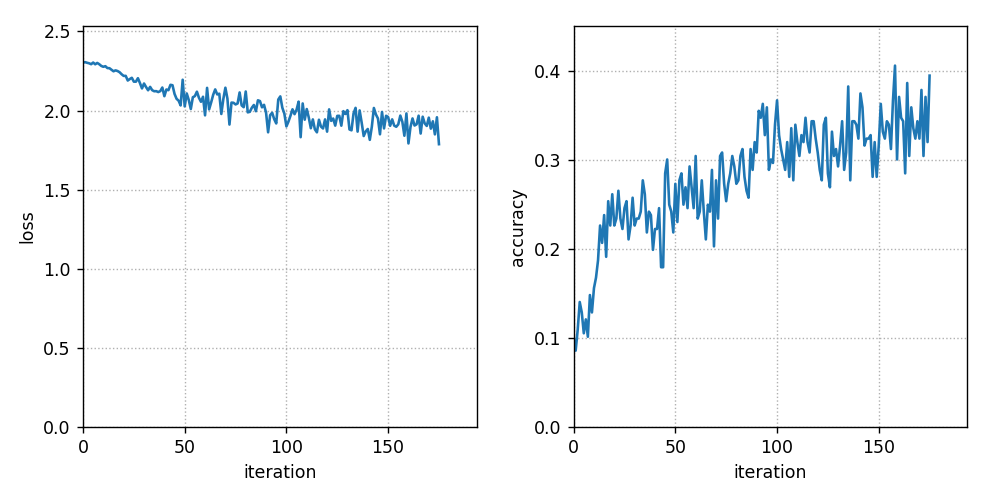

Epoch 1/1
Training...
100%|██████████| 176/176 [00:46<00:00,  3.80it/s]
Validating...
100%|██████████| 20/20 [00:04<00:00,  4.73it/s]
Saving TEST.model

Evaluating TEST on train set
100%|██████████| 196/196 [00:26<00:00,  7.40it/s]
  loss = 1.8917
  accy = 0.3446
Evaluating TEST on test set
100%|██████████| 40/40 [00:07<00:00,  5.30it/s]
  loss = 1.8941
  accy = 0.3426



((1.8916559590368855, 0.3446069834183674), (1.89406216442585, 0.342578125))

In [30]:
def train_and_evaluate(
    model_name: str,
    train_set_dir: str,
    test_set_dir: str,
    batch_size: int,
    n_hidden: int,
    activ_fn: str,
    dropout: float,
    optimizer: str,
    learning_rate: float,
    weight_decay: float,
    n_epochs: int,
    verbose=False
): 
    # load train and test datasets
    image_transform = lambda x: torch.flatten(x / 255 - 0.5).float()
    label_transform = lambda x: F.one_hot(x, CifarDataset.label_size).float()
    train_dataset = CifarDataset.from_dir(train_set_dir, image_transform, label_transform, device='cuda')
    test_dataset  = CifarDataset.from_dir(test_set_dir, image_transform, label_transform, device='cuda')
    
    # define model architecture
    model = MultiLayerPerceptronModel(
        n_input=np.prod(CifarDataset.data_shape),
        n_hidden=n_hidden,
        n_output=CifarDataset.label_size,
        activ_fn=activ_fn,
        dropout=dropout
    ).cuda()
    
    # configure optimizer
    optimizer = getattr(torch.optim, optimizer)(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )
    
    print(f'Training {model_name}')
    training(train_dataset, model, optimizer, batch_size, n_epochs, verbose)
    
    print(f'Saving {model_name}.model')
    torch.save(model.state_dict(), f'{model_name}.model')
    print()
    
    print(f'Evaluating {model_name} on train set')
    train_metrics = evaluation(train_dataset, model, batch_size, verbose)

    print(f'Evaluating {model_name} on test set')
    test_metrics  = evaluation(test_dataset, model, batch_size, verbose)
    print()

    return train_metrics, test_metrics


train_and_evaluate(
    model_name='TEST',
    train_set_dir=train_set_dir,
    test_set_dir=test_set_dir,
    batch_size=256,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=1e-3,
    weight_decay=0,
    n_epochs=1,
    verbose=True
)

In [31]:
def run_experiment(name_format, eval_fn, base_config, var_name, var_values):
    
    results = pd.DataFrame(columns=[var_name, 'phase', 'loss', 'accy'])
    results.set_index([var_name, 'phase'], inplace=True)
    
    for value in var_values:
        model_name = name_format.format(**{var_name: value})
        config = base_config.copy()
        config[var_name] = value

        train_metrics, test_metrics = eval_fn(model_name, train_set_dir, test_set_dir, **config)
        results.loc[(value, 'train'), :] = train_metrics
        results.loc[(value, 'test'), :]  = test_metrics
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    sns.barplot(results, x=var_name, y='loss', hue='phase', ax=ax[0])
    sns.barplot(results, x=var_name, y='accy', hue='phase', ax=ax[1])
    for ax_ in ax:
        ax_.legend(loc='lower right')
        ax_.set_axisbelow(True)
        ax_.grid(linestyle=':')
    
    fig.tight_layout()
    fig.canvas.draw()
    
    return results.unstack(1)

## Experiment 1: learning rate

First, we evaluate the effect of learning rate. In this experiment we use learning rates [1e-2, 3e-3, 1e-3, 3e-4, 1e-4].

Training learning_rate__1e-02


<IPython.core.display.Javascript object>


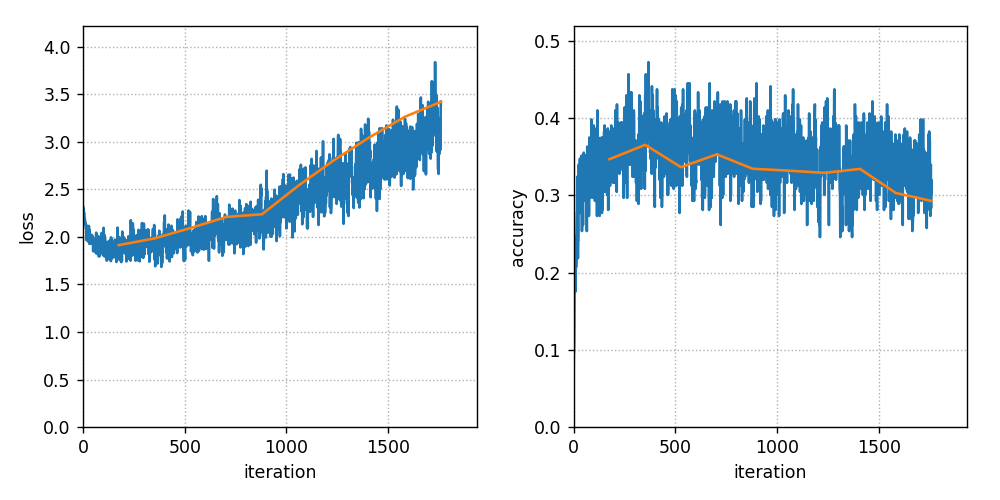

100%|██████████| 10/10 [05:29<00:00, 32.91s/it]
Saving learning_rate__1e-02.model

Evaluating learning_rate__1e-02 on train set
Evaluating learning_rate__1e-02 on test set

Training learning_rate__3e-03


<IPython.core.display.Javascript object>


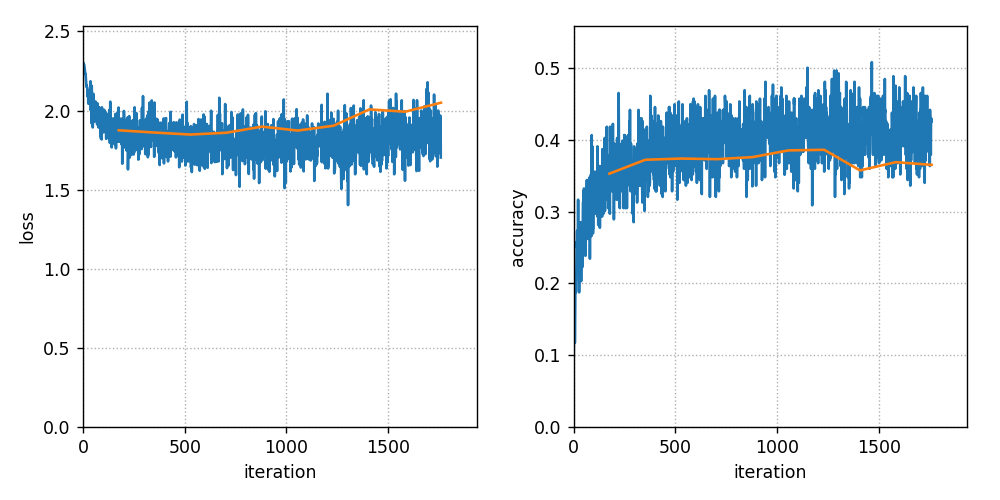

100%|██████████| 10/10 [04:07<00:00, 24.77s/it]
Saving learning_rate__3e-03.model

Evaluating learning_rate__3e-03 on train set
Evaluating learning_rate__3e-03 on test set

Training learning_rate__1e-03


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [04:04<00:00, 24.42s/it]
Saving learning_rate__1e-03.model

Evaluating learning_rate__1e-03 on train set
Evaluating learning_rate__1e-03 on test set

Training learning_rate__3e-04


<IPython.core.display.Javascript object>


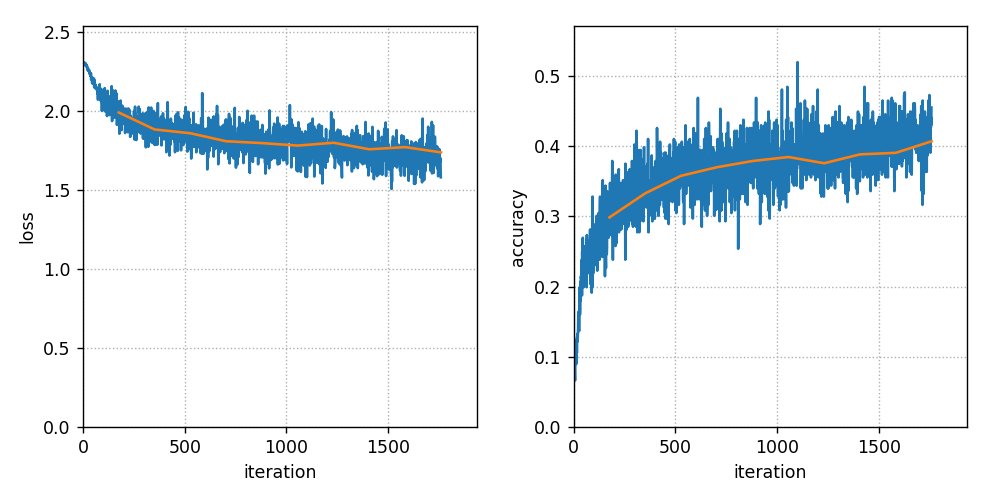

100%|██████████| 10/10 [04:04<00:00, 24.47s/it]
Saving learning_rate__3e-04.model

Evaluating learning_rate__3e-04 on train set
Evaluating learning_rate__3e-04 on test set

Training learning_rate__1e-04


<IPython.core.display.Javascript object>


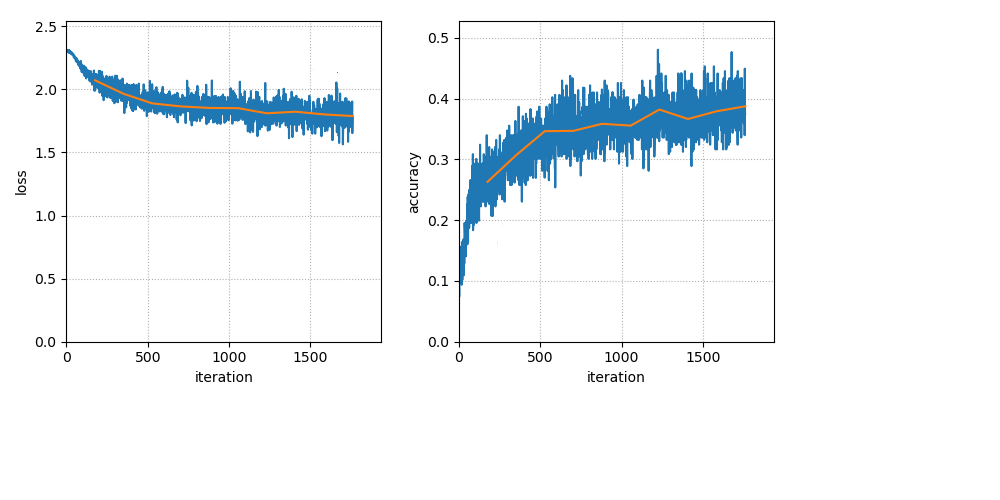

100%|██████████| 10/10 [04:05<00:00, 24.54s/it]
Saving learning_rate__1e-04.model

Evaluating learning_rate__1e-04 on train set
Evaluating learning_rate__1e-04 on test set



<IPython.core.display.Javascript object>


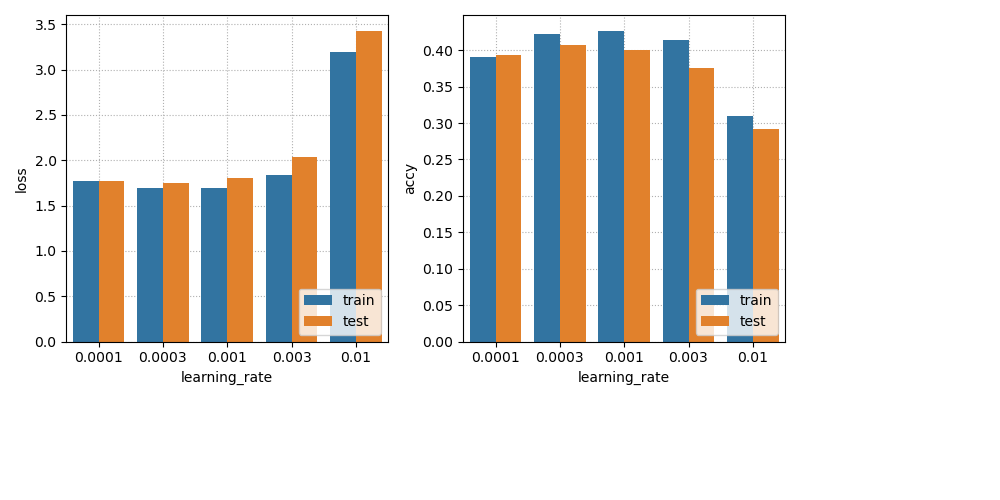

CPU times: user 18min 22s, sys: 3min 25s, total: 21min 48s
Wall time: 23min 38s


loss                accy          
phase             train      test     train      test
learning_rate                                        
0.0100         3.192331  3.430997  0.309977  0.291895
0.0030         1.837831  2.038693  0.413413  0.375977
0.0010         1.695032   1.80148  0.426965  0.400293
0.0003         1.688832  1.743826  0.422238  0.407422
0.0001         1.776231  1.774443  0.390657  0.392773

In [32]:
%%time

base_config = dict(
    batch_size=256,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=1e-3,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='learning_rate__{learning_rate:.0e}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='learning_rate',
    var_values=[1e-2, 3e-3, 1e-3, 3e-4, 1e-4]
)

The best learning rate in terms of accuracy on the test set was 3e-4, which reached a test accuracy of 40.74%. The best in terms of cross entropy loss on the test set was 1e-3, which converged to test loss of 1.80 but had slightly worse test accuracy of 40.03%. The worst learning rate was 1e-2, which caused the loss to diverge during training.

## Experiment 2: Optimizer

Next we evaluate the effect of the optimization algorithm. For this experiment we try using stochastic gradient descent (SGD), Adam, or RMSprop for the optimizer. For simplicity, we use the same learning rate of 3e-4 for each optimizer.

Training optimizer__SGD


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [04:27<00:00, 26.78s/it]
Saving optimizer__SGD.model

Evaluating optimizer__SGD on train set
Evaluating optimizer__SGD on test set

Training optimizer__Adam


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [04:15<00:00, 25.52s/it]
Saving optimizer__Adam.model

Evaluating optimizer__Adam on train set
Evaluating optimizer__Adam on test set

Training optimizer__RMSprop


<IPython.core.display.Javascript object>


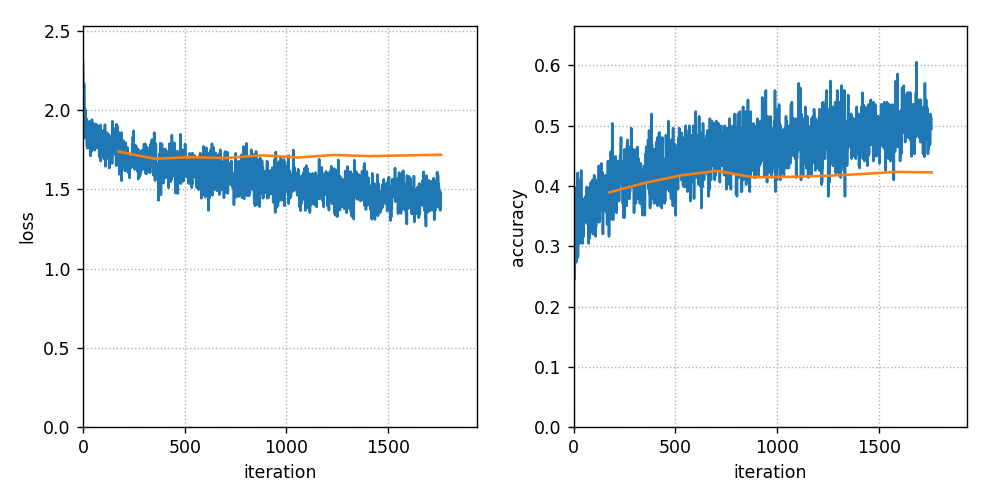

100%|██████████| 10/10 [04:32<00:00, 27.28s/it]
Saving optimizer__RMSprop.model

Evaluating optimizer__RMSprop on train set
Evaluating optimizer__RMSprop on test set



<IPython.core.display.Javascript object>


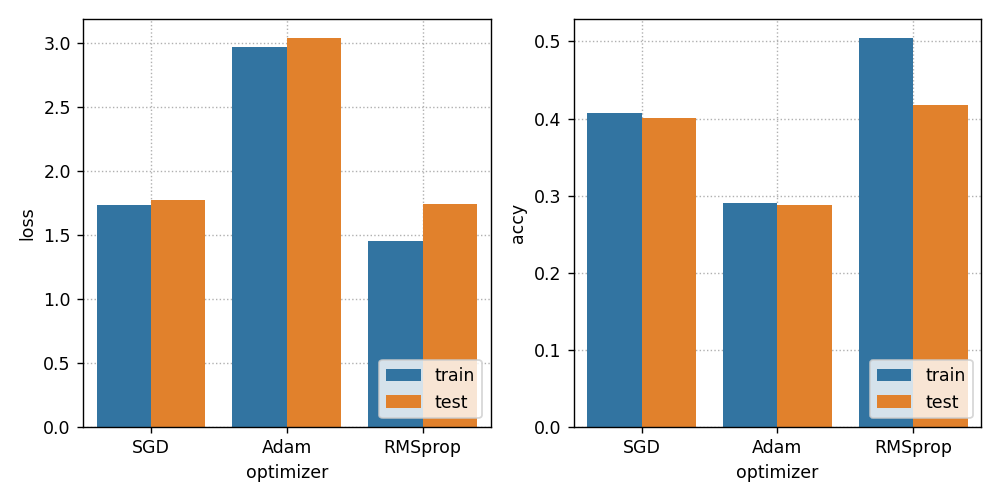

loss                accy          
phase         train      test     train      test
optimizer                                        
SGD        1.731463  1.773291  0.406876  0.400977
Adam       2.968927  3.037846  0.290796  0.287695
RMSprop    1.452002  1.739688  0.504209   0.41709

In [33]:
base_config = dict(
    batch_size=256,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=3e-4,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='optimizer__{optimizer}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='optimizer',
    var_values=['SGD', 'Adam', 'RMSprop']
)

The best optimization algorithm in quantitative terms for this model was RMSprop, which reached test loss of 1.74 and accuracy of 41.71%. The second best optimizer was SGD, which had test loss of 1.77 and test accuracy of 40.09%. Adam did not perform well using the settings we tried- it had both oscillation and divergence during training. This may be due to the fact that the learning rate we used was too high for the Adam optimizer, which typically is effectively applied to larger models and uses a much lower learning rate than we chose.

## Experiment 3: Batch size

In the third experiment, we explore the effect of batch size. We trained models using batch sizes [128, 256, 512]. All the models were trained using SGD with learning rate 3e-4.

Training batch_size__128


<IPython.core.display.Javascript object>


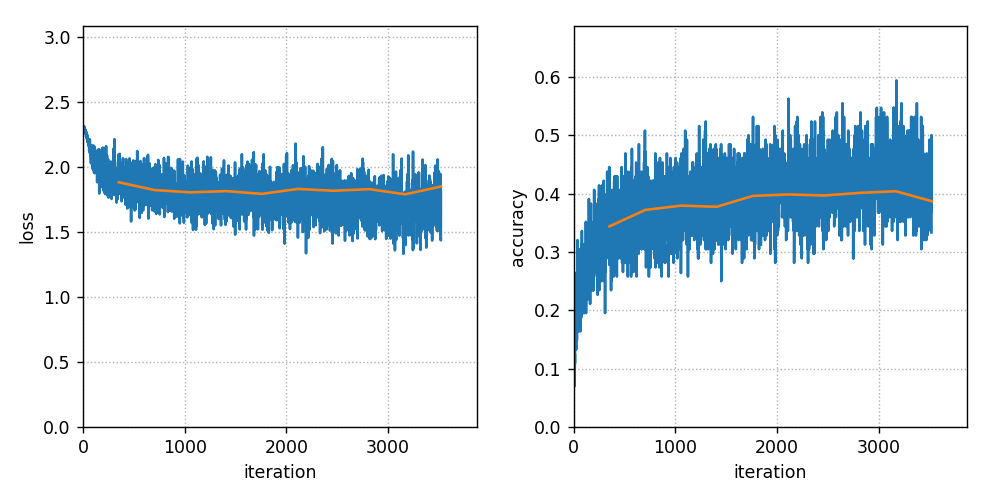

100%|██████████| 10/10 [06:57<00:00, 41.74s/it]
Saving batch_size__128.model

Evaluating batch_size__128 on train set
Evaluating batch_size__128 on test set

Training batch_size__256


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [45:01<00:00, 270.20s/it]
Saving batch_size__256.model

Evaluating batch_size__256 on train set
Evaluating batch_size__256 on test set

Training batch_size__512


<IPython.core.display.Javascript object>


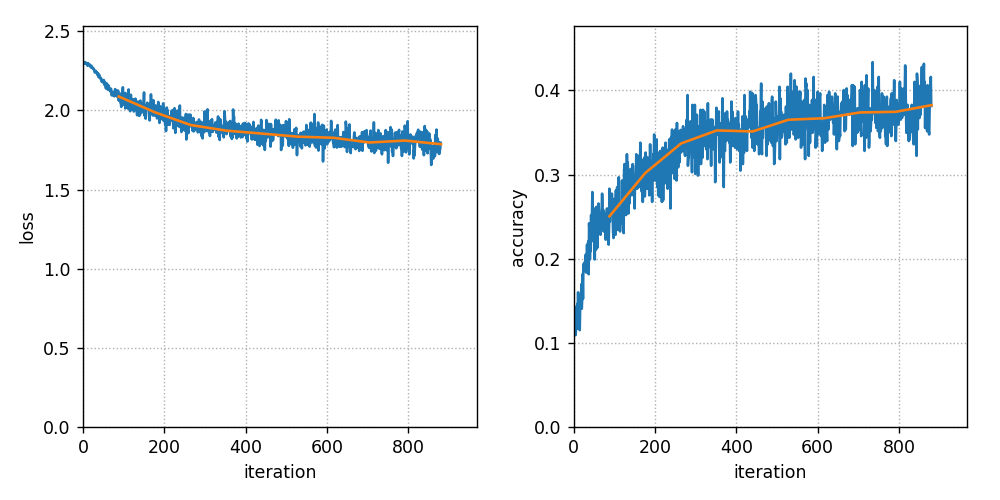

100%|██████████| 10/10 [34:26<00:00, 206.67s/it]
Saving batch_size__512.model

Evaluating batch_size__512 on train set
Evaluating batch_size__512 on test set



<IPython.core.display.Javascript object>


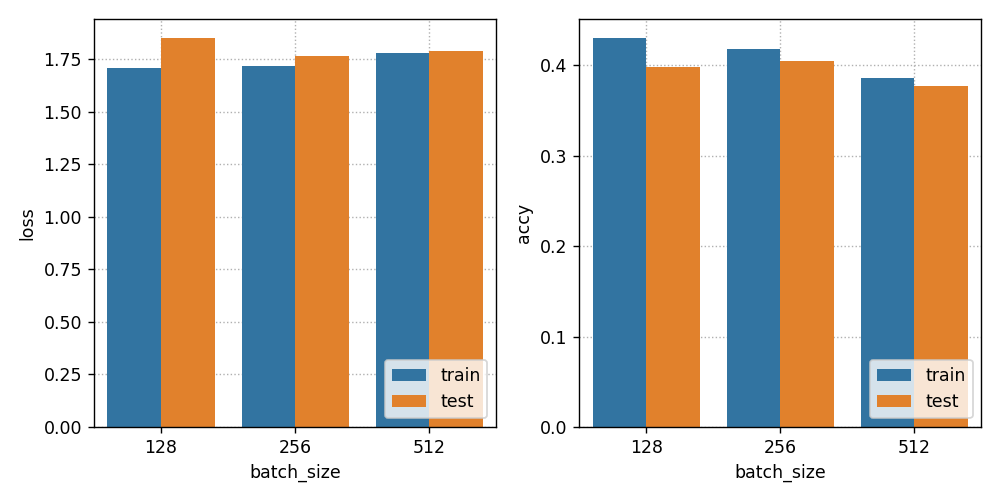

loss                accy          
phase          train      test     train      test
batch_size                                        
128         1.708747  1.850083  0.430099   0.39824
256         1.715857  1.765003  0.418308  0.404785
512         1.779482  1.788851  0.385569  0.377281

In [34]:
base_config = dict(
    batch_size=256,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=3e-4,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='batch_size__{batch_size}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='batch_size',
    var_values=[128, 256, 512]
)

The ideal batch size for this model and optimizer was 256, which resulted in test loss of 1.77 and test accuracy of 40.48%. The larger size of 512 and lower size of 128 both produced worse test loss and accuracy than batch size of 256. It is interesting to note that the lower batch size of 128 showed signs of overfitting compared to 256, since batch size 128 had lower train loss and higher train accuracy than 256, but worse test performance.

## Experiment 4: Hidden units

Next we modify the number of hidden units in the model from [64, 128, 256]. All models were trained using SGD with learning rate 3e-4 and batch size 256.

Training n_hidden__64


<IPython.core.display.Javascript object>


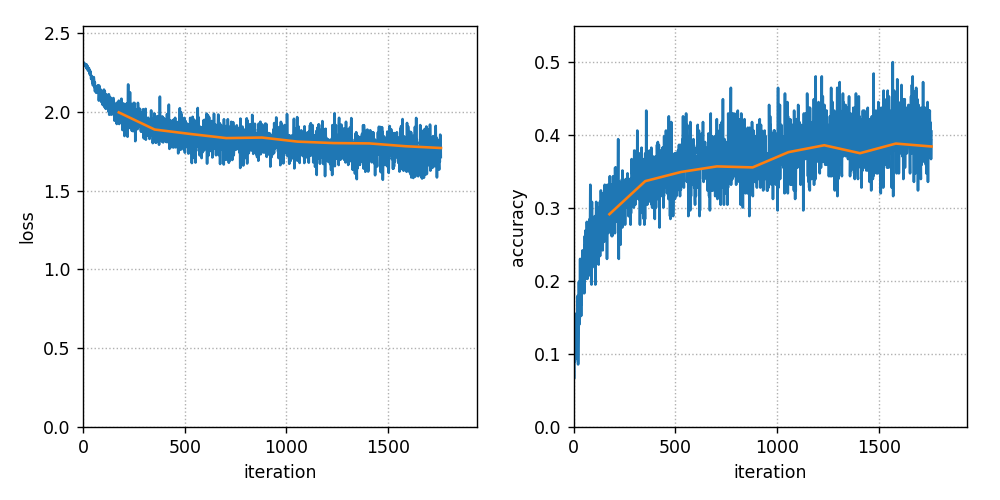

100%|██████████| 10/10 [04:48<00:00, 28.81s/it]
Saving n_hidden__64.model

Evaluating n_hidden__64 on train set
Evaluating n_hidden__64 on test set

Training n_hidden__128


<IPython.core.display.Javascript object>


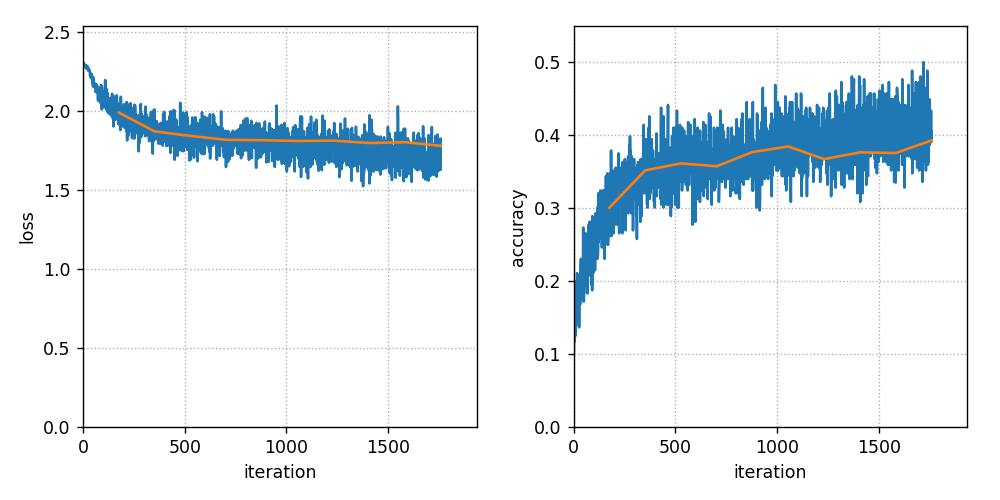

100%|██████████| 10/10 [04:39<00:00, 27.96s/it]
Saving n_hidden__128.model

Evaluating n_hidden__128 on train set
Evaluating n_hidden__128 on test set

Training n_hidden__256


<IPython.core.display.Javascript object>


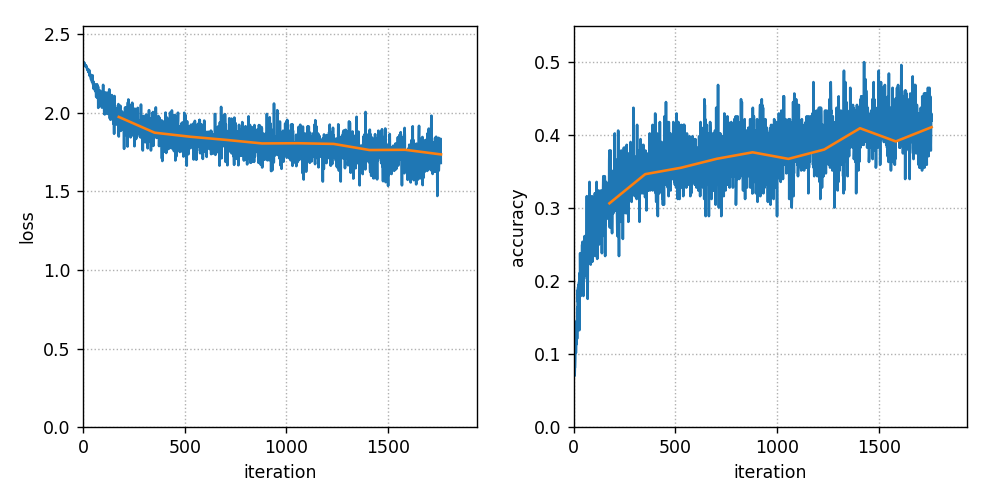

100%|██████████| 10/10 [04:40<00:00, 28.01s/it]
Saving n_hidden__256.model

Evaluating n_hidden__256 on train set
Evaluating n_hidden__256 on test set



<IPython.core.display.Javascript object>

loss                accy          
phase        train      test     train      test
n_hidden                                        
64        1.733411  1.770079  0.403783  0.387012
128       1.738262  1.807152   0.41252  0.402148
256       1.689446  1.744246  0.421927  0.403613

In [35]:
base_config = dict(
    batch_size=256,
    n_hidden=128,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=3e-4,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='n_hidden__{n_hidden}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='n_hidden',
    var_values=[64, 128, 256]
)

The best test loss (1.74) and accuracy (40.36%) were achieved by increasing the number of hidden units to 256. There was a slight but steady trend of improving train and test accuracy when hidden units were increased from 64, to 128, to 256.

## Experiment 5: Dropout

Next we apply different levels of dropout to the model with probabilty [0, 0.25, 0.50] to see the effect. The models used SGD with learning rate 3e-4, batch size 256, and 256 hidden units.

Training dropout__0.00


<IPython.core.display.Javascript object>


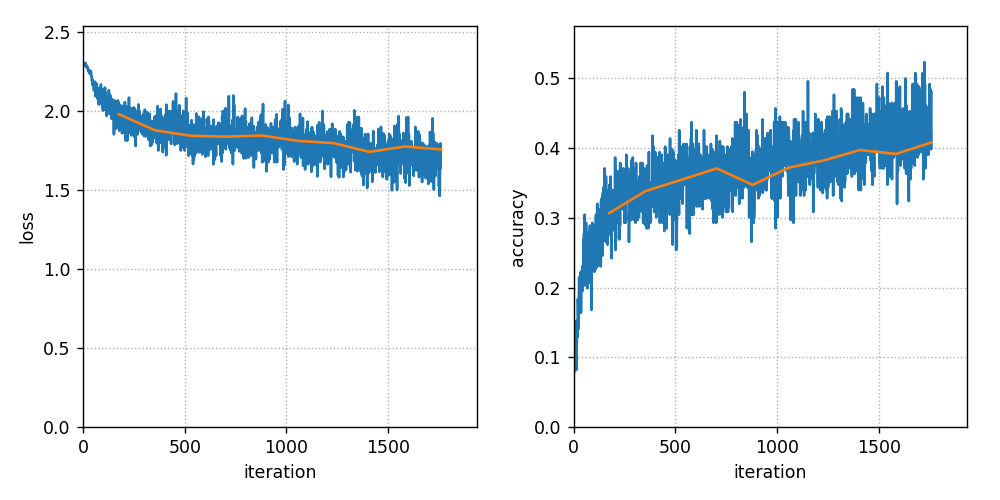

100%|██████████| 10/10 [05:28<00:00, 32.84s/it]
Saving dropout__0.00.model

Evaluating dropout__0.00 on train set
Evaluating dropout__0.00 on test set

Training dropout__0.25


<IPython.core.display.Javascript object>


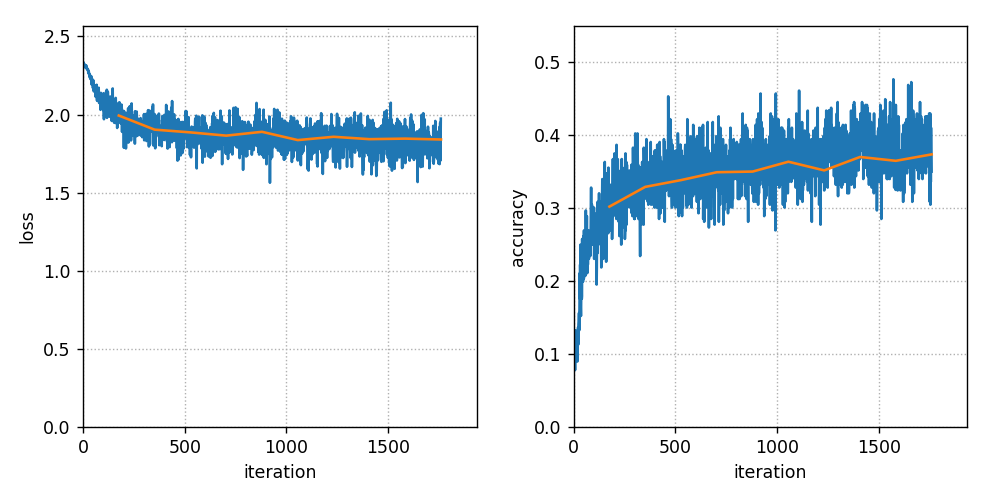

100%|██████████| 10/10 [05:26<00:00, 32.68s/it]
Saving dropout__0.25.model

Evaluating dropout__0.25 on train set
Evaluating dropout__0.25 on test set

Training dropout__0.50


<IPython.core.display.Javascript object>


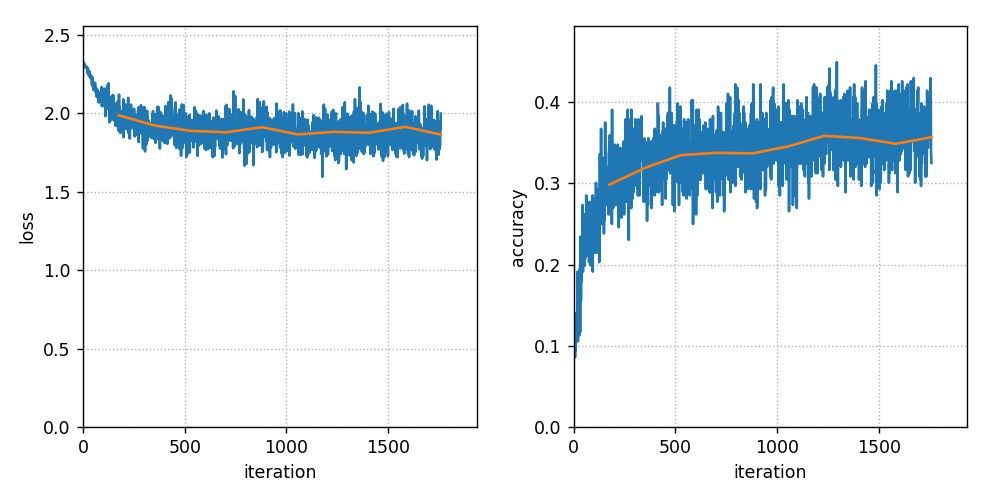

100%|██████████| 10/10 [06:20<00:00, 38.03s/it]
Saving dropout__0.50.model

Evaluating dropout__0.50 on train set
Evaluating dropout__0.50 on test set



<IPython.core.display.Javascript object>


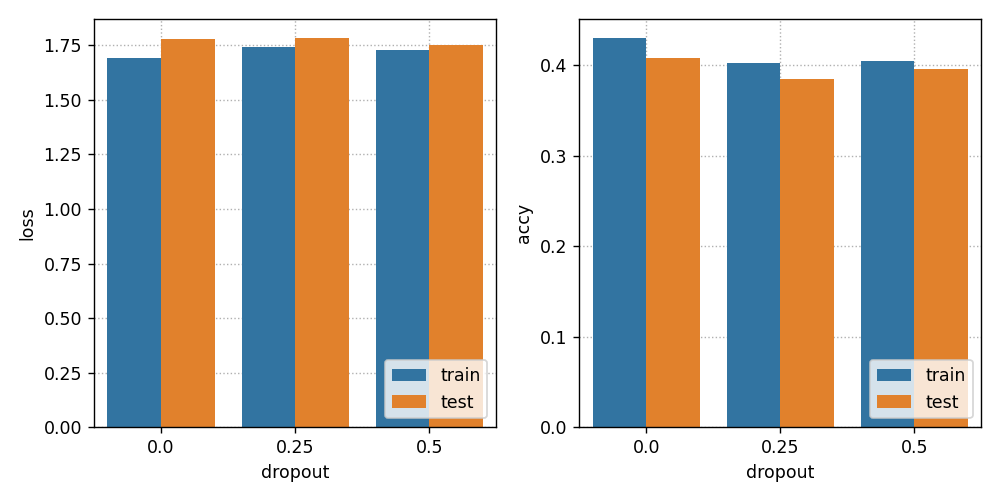

loss                accy          
phase       train      test     train      test
dropout                                        
0.00     1.693743  1.780979  0.430178  0.408691
0.25     1.741493  1.782628  0.402276  0.385449
0.50     1.728673  1.751305  0.404512  0.395801

In [36]:
base_config = dict(
    batch_size=256,
    n_hidden=256,
    activ_fn='tanh',
    dropout=0.0,
    optimizer='SGD',
    learning_rate=3e-4,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='dropout__{dropout:.2f}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='dropout',
    var_values=[0.00, 0.25, 0.50]
)

Somewhat surprisingly, we see that applying dropout hurt the test performance. The best test accuracy (40.87%) was achieved from using dropout probability of zero, whereas probability of 0.25 or 0.50 resulted in test accuracy of 38.54% or 39.58%, respectively.

## Experiment 6: Weight decay

Finally, we explore the effect of weight decay (i.e. L2 regularization) on the model using regularization weights of [0,1e-6, 1e-5]. The models were all trained with SGD, learning rate 3e-4, batch size 256, 256 hidden units, and no dropout.

Training weight_decay__0e+00


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [06:36<00:00, 39.66s/it]
Saving weight_decay__0e+00.model

Evaluating weight_decay__0e+00 on train set
Evaluating weight_decay__0e+00 on test set

Training weight_decay__1e-06


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [07:42<00:00, 46.21s/it]
Saving weight_decay__1e-06.model

Evaluating weight_decay__1e-06 on train set
Evaluating weight_decay__1e-06 on test set

Training weight_decay__1e-05


<IPython.core.display.Javascript object>

100%|██████████| 10/10 [06:08<00:00, 36.82s/it]
Saving weight_decay__1e-05.model

Evaluating weight_decay__1e-05 on train set
Evaluating weight_decay__1e-05 on test set



<IPython.core.display.Javascript object>


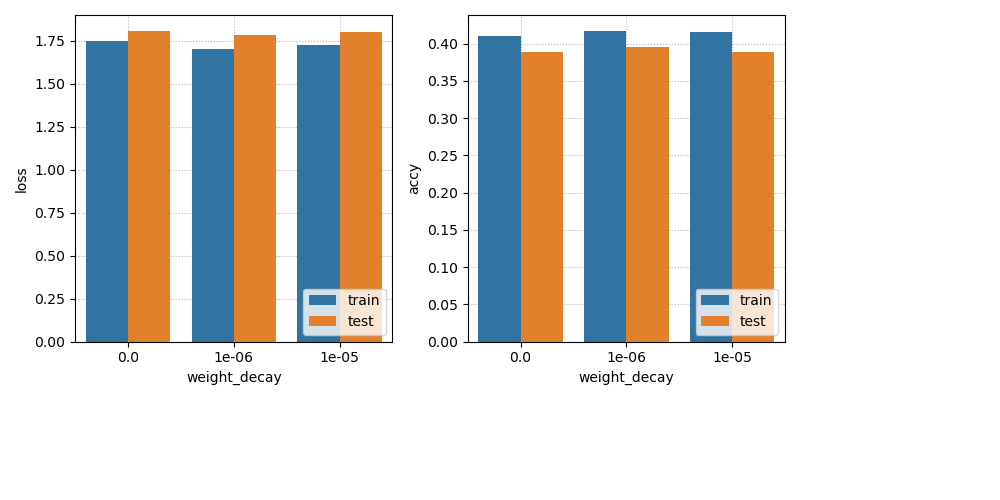

loss                accy          
phase            train      test     train      test
weight_decay                                        
0.000000      1.749742  1.809533  0.410479   0.38916
0.000001      1.699858  1.782184  0.417706  0.395898
0.000010      1.724606   1.80233  0.416195  0.388281

In [37]:
base_config = dict(
    batch_size=256,
    n_hidden=256,
    activ_fn='tanh',
    dropout=0,
    optimizer='SGD',
    learning_rate=3e-4,
    weight_decay=0,
    n_epochs=10
)

run_experiment(
    name_format='weight_decay__{weight_decay:.0e}',
    eval_fn=train_and_evaluate,
    base_config=base_config,
    var_name='weight_decay',
    var_values=[0, 1e-6, 1e-5]
)

When no L2 regularization was used, the model had test accuracy of 38.91%. This increased to 39.59% when we applied weight decay of 1e-6, but then it decreased to 38.83% when it was further increased to 1e-5. Therefore, a very small amount of weight decay did help improve the test performance.

# Part C - Transfer learning

Now we compare two different transfer learning approaches using the MobileNetV2 pretrained model for CIFAR10 image classification. After replacing the final linear classification layer in the model, we either finetune all of the model parameters using the CIFAR10 training set, or only the final classification layer.

Training TEST


<IPython.core.display.Javascript object>


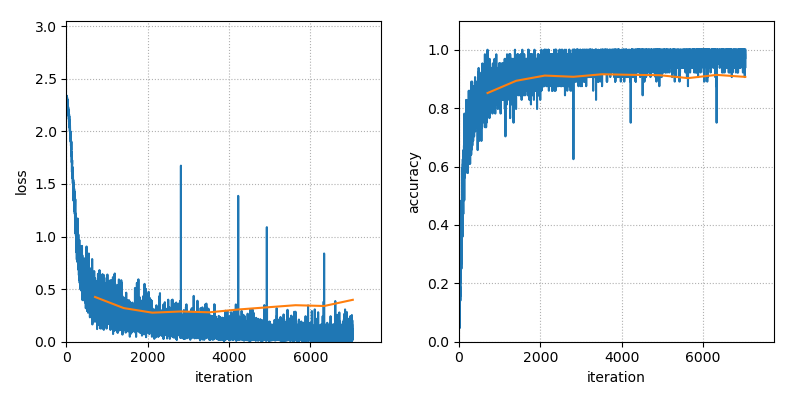

Epoch 1 / 10
Training...
100%|██████████| 704/704 [06:15<00:00,  1.87it/s]
Validating...
100%|██████████| 79/79 [00:19<00:00,  4.02it/s]
Epoch 2 / 10
Training...
100%|██████████| 704/704 [03:07<00:00,  3.75it/s]
Validating...
100%|██████████| 79/79 [00:12<00:00,  6.39it/s]
Epoch 3 / 10
Training...
100%|██████████| 704/704 [02:55<00:00,  4.01it/s]
Validating...
100%|██████████| 79/79 [00:12<00:00,  6.35it/s]
Epoch 4 / 10
Training...
100%|██████████| 704/704 [02:58<00:00,  3.95it/s]
Validating...
100%|██████████| 79/79 [00:12<00:00,  6.25it/s]
Epoch 5 / 10
Training...
100%|██████████| 704/704 [02:59<00:00,  3.93it/s]
Validating...
100%|██████████| 79/79 [00:12<00:00,  6.33it/s]
Epoch 6 / 10
Training...
100%|██████████| 704/704 [03:03<00:00,  3.84it/s]
Validating...
100%|██████████| 79/79 [00:18<00:00,  4.25it/s]
Epoch 7 / 10
Training...
100%|██████████| 704/704 [03:25<00:00,  3.43it/s]
Validating...
100%|██████████| 79/79 [00:21<00:00,  3.68it/s]
Epoch 8 / 10
Training...
100%|██████████|

((0.05532263794346996, 0.9837755754475703),
 (0.3152211708295497, 0.9251592356687898))

In [22]:
import torchvision.transforms.functional as TVF

def transfer_learning(
    model_name: str,
    train_set_dir: str,
    test_set_dir: str,
    batch_size: str,
    optimizer: str,
    finetune_all: bool,
    learning_rate: float,
    weight_decay: float,
    n_epochs: int,
    verbose=False
):
    # load train and test datasets
    image_transform = lambda x: TVF.resize(x / 255 - 0.5, (224, 224), antialias=True)
    label_transform = lambda x: F.one_hot(x, CifarDataset.label_size).float()
    train_dataset = CifarDataset.from_dir(train_set_dir, image_transform, label_transform, device='cuda')
    test_dataset  = CifarDataset.from_dir(test_set_dir, image_transform, label_transform, device='cuda')
    
    # load pre-trained model and replace classifier layer
    model = torchvision.models.mobilenet_v2(weights='DEFAULT').cuda()
    model.classifier[-1] = torch.nn.Linear(
        model.classifier[-1].in_features, CifarDataset.label_size
    ).cuda()

    # configure optimizer
    if finetune_all:
        parameters = model.parameters()
    else:
        parameters = model.classifier[-1].parameters()
    
    optimizer = getattr(torch.optim, optimizer)(
        parameters, lr=learning_rate, weight_decay=weight_decay
    )
    
    print(f'Training {model_name}')
    training(train_dataset, model, optimizer, batch_size, n_epochs, verbose)
    
    print(f'Saving {model_name}.model')
    torch.save(model.state_dict(), f'{model_name}.model')
    print()
    
    print(f'Evaluating {model_name} on train set')
    train_metrics = evaluation(train_dataset, model, batch_size, verbose)

    print(f'Evaluating {model_name} on test set')
    test_metrics  = evaluation(test_dataset, model, batch_size, verbose)
    print()

    return train_metrics, test_metrics


transfer_learning(
    model_name='TEST',
    train_set_dir=train_set_dir,
    test_set_dir=test_set_dir,
    batch_size=64,
    optimizer='Adam',
    finetune_all=True,
    learning_rate=1e-5,
    weight_decay=0,
    n_epochs=3,
    verbose=True
)

For this evaluation, we use a smaller batch size of 64 due to CUDA memory constraints, and we train using the Adam optimizer with a learning rate of 1e-5. The models were not finetuned with any L2 regularization, and we also reduced the total training time from 10 epochs to 3. The key variable was whether we finetune ALL of the model parameters, or only the final layer.

Training finetune__0


<IPython.core.display.Javascript object>


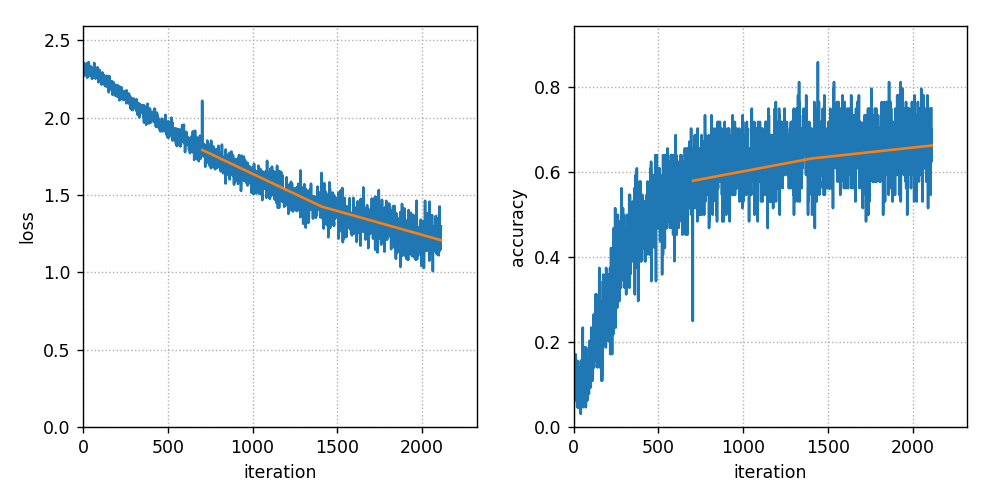

100%|██████████| 3/3 [11:55<00:00, 238.65s/it]
Saving finetune__0.model

Evaluating finetune__0 on train set
Evaluating finetune__0 on test set

Training finetune__1


<IPython.core.display.Javascript object>

100%|██████████| 3/3 [10:13<00:00, 204.41s/it]
Saving finetune__1.model

Evaluating finetune__1 on train set
Evaluating finetune__1 on test set



<IPython.core.display.Javascript object>


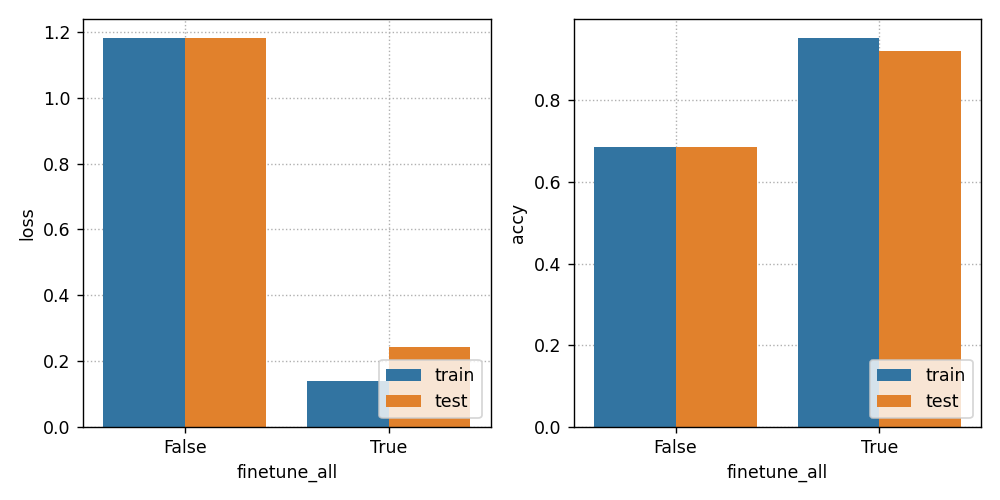

CPU times: user 18min 58s, sys: 1min 35s, total: 20min 33s
Wall time: 26min 9s


loss                accy          
phase            train      test     train      test
finetune_all                                        
False         1.180916  1.181165  0.684763  0.686206
True          0.140722  0.243113  0.951746  0.919885

In [25]:
%%time

base_config = dict(
    batch_size=64,
    optimizer='Adam',
    finetune_all=False,
    learning_rate=1e-5,
    weight_decay=0,
    n_epochs=3,
)

run_experiment(
    name_format='finetune__{finetune_all:d}',
    eval_fn=transfer_learning,
    base_config=base_config,
    var_name='finetune_all',
    var_values=[False, True]
)

We see that much better test performance were achieved by finetuning ALL of the model parameters. When all parameters were trained, the model reached test loss of 0.24 and accuracy of 91.99%, compared to loss of 1.18 and accuracy of 68.62% when only the final classifier was trained. It is notable that in both cases, the results were much better than we previously achieved in any of the experiments based on a 3 layer fully connected network, and in far fewer training epochs. This shows the importance of convolutional model architectures for image classification and the effectiveness of transfer learning for efficent and accurate downstream classification tasks.